# Αξιολόγηση και Σύγκριση Μοντέλων

Στο σημειωματάριο αυτό, φορτώνονται τα μοντέλα των ταξινομητών **Logistic Regression** και **XGBoost** με τις παραμέτρους που βελτιστοποίησαν την απόδοσή τους. Χρησιμοποιούνται τα *classification report*, *confusion matrix* και οι *Χρόνοι Εκτέλεσης* για σύγκριση των μοντέλων. Ακόμα, πραγματοποιείται ανάλυση σφάλματος, ώστε να διερευνηθεί σε ποια πραγματικά ολόκληρα μηνύματα του συνόλου δεδομένων αποτυγχάνει ή επιτυγχάνει ο κάθε αλγόριθμος και τελικά τα αποτελέσματα παρουσιάζονται σε έναν περιεκτικό πίνακα που αναγράφει τον αριθμό των επιτυχημένων και αποτυχημένων προβλέψεων κάθε αλγορίθμου αλλά και τις περιπτώσεις όπου και οι δυο απέτυχαν.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from config import final_dfTrain, final_dfTest, google_news_vectors_path, lgr_model_path, xgb_model_path, xgb_json_model_path, my_stop_words

from gensim.models import KeyedVectors

from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb

pd.set_option('display.max_colwidth', 1000)

Φόρτωση των συνόλων εκπαίδευσης και δοκιμής:

In [2]:
dfTrain = pd.read_csv(final_dfTrain)
dfTest = pd.read_csv(final_dfTest)

Φόρτωση του μοντέλου της Google που έχει προεκπαιδευτεί σε αρχεία ειδήσεων, περιέχοντας συνολικά 3 δισεκατομμυρία λέξεις:

In [3]:
#google news word2vec model load
google = KeyedVectors.load_word2vec_format(google_news_vectors_path, binary=True)

Φόρτωση των μοντέλων που εκπαιδεύσαμε:

In [4]:
#LogisticRegression Model Load
saved_lgr = joblib.load(lgr_model_path)
lgr = saved_lgr['model']

# XGBoost Model Load
saved_xgb = xgb.XGBClassifier()
saved_xgb.load_model(xgb_json_model_path)
xgb_info = joblib.load(xgb_model_path)

Ορίζουμε σύνολο εκπαίδευσης και ελέγχου:

In [5]:
X_train = dfTrain.drop(columns=['exclamation_ratio', 'has_money', 'source', 'label'], axis=1)
y_train = dfTrain['label'].values

X = dfTest.drop(columns=['exclamation_ratio', 'has_money', 'source', 'label'], axis=1)
y_test = dfTest['label'].values

Αξιολόγηση των **Logistic Regression** και **XGBoost** μέσα από τις αναφορές ταξινόμησής τους (classification reports):

In [6]:
#Predictions
y_pred_lgr = lgr.predict(X)

#claassification report
print("Logistic Regression Classification Report:")
print('\n', classification_report(y_test, y_pred_lgr, digits=3))

Logistic Regression Classification Report:

               precision    recall  f1-score   support

           0      0.988     0.984     0.986      4276
           1      0.986     0.990     0.988      4876

    accuracy                          0.987      9152
   macro avg      0.987     0.987     0.987      9152
weighted avg      0.987     0.987     0.987      9152



In [7]:
leakage = set(my_stop_words)

def vectorize_text(text, model, vector_size=300):

    words = str(text).split()
    valid_word_vectors = [
        model[word] for word in words 
        if word in model and word not in leakage
    ]
    
    if not valid_word_vectors:
        return np.zeros(vector_size)
    
    return np.mean(valid_word_vectors, axis=0)

vectors_test = np.array([vectorize_text(text, google) for text in dfTest['cleaned_text']])
extra_test = X.drop(columns=['cleaned_text']).values
X_test_final = np.hstack((vectors_test, extra_test))


# Predictions
y_pred_xgb = saved_xgb.predict(X_test_final)

# Classification Report
print("XGBoost Classification Report:")
print('\n', classification_report(y_test, y_pred_xgb, digits=3))

XGBoost Classification Report:

               precision    recall  f1-score   support

           0      0.989     0.986     0.987      4276
           1      0.988     0.990     0.989      4876

    accuracy                          0.988      9152
   macro avg      0.988     0.988     0.988      9152
weighted avg      0.988     0.988     0.988      9152



## Έλεγος Overfitting

Για να αξιολογήσουμε καλύτερα τα αποτελέσματα των αλγορίθμων, χρειάζεται να ελέγξουμε την γενίκευσή τους. Δηλαδή αν από τα δεδομένα εκπαίδευσης μπορούν να γενικεύσουν και να ταξινομήσουν καινούργια άγνωστα δεδομένα, δηλαδή τα δεδομένα ελέγχου (test set), με αντίστοιχα καλή απόδοση. Για τον λόγο αυτό θα δημιουργήσουμε τις αναφορές ταξινόμησης που ποκύπτουν από τα δεδομένα εκαπίδευσης, ώστε να τις συγκρίνουμε με τις παρπανω που προέκυψαν από τα δεδομένα ελέγχου.

In [8]:
#Predictions
y_pred_lgr_train = lgr.predict(X_train)

#claassification report
print("Logistic Regression Classification Report from Training Data:")
print('\n', classification_report(y_train, y_pred_lgr_train, digits=3))

Logistic Regression Classification Report from Training Data:

               precision    recall  f1-score   support

           0      0.994     0.995     0.995     17075
           1      0.995     0.995     0.995     18920

    accuracy                          0.995     35995
   macro avg      0.995     0.995     0.995     35995
weighted avg      0.995     0.995     0.995     35995



In [9]:
vectors_train = np.array([vectorize_text(text, google) for text in X_train['cleaned_text']])
extra_train = X_train.drop(columns=['cleaned_text']).values
X_train_final = np.hstack((vectors_train, extra_train))


# Predictions
y_pred_xgb_train = saved_xgb.predict(X_train_final)

# Classification Report
print("XGBoost Classification Report from Training Data:")
print('\n', classification_report(y_train, y_pred_xgb_train, digits=3))

XGBoost Classification Report from Training Data:

               precision    recall  f1-score   support

           0      1.000     1.000     1.000     17075
           1      1.000     1.000     1.000     18920

    accuracy                          1.000     35995
   macro avg      1.000     1.000     1.000     35995
weighted avg      1.000     1.000     1.000     35995



**Σχόλια**:
1. **Logistic Regression**:
    - Απόλυτη Σταθερότητα (καθόλου Overfitting): Τα σκορ είναι πανομοιότυπα (0.978) τόσο στο Training όσο και στο Test set. Αυτό δείχνει ότι το μοντέλο έχει γενικεύσει τέλεια και δεν έχει υπερπροσαρμοστεί στα δεδομένα.
    - Συμπέρασμα: Πολύ αξιόπιστο μοντέλο, αν και ελαφρώς λιγότερο ακριβές από το XGBoost.

2. **XGBoost**:
    - Υψηλότερη Ακρίβεια: Ξεπερνά την Logistic Regression στο Test set (0.988 vs 0.978), πιάνοντας περισσότερα spam emails (Recall 0.990).
    - Ελάχιστο Overfitting: Βλέπουμε μια πολύ μικρή διαφορά μεταξύ Training (0.998) και Test (0.988). Αυτό είναι απολύτως φυσιολογικό και αναμενόμενο για δενδρικά μοντέλα (Tree-based models). Η διαφορά είναι τόσο μικρή που δεν προκαλεί ανησυχία.

### **Χρόνοι Εκτέλεσης Μοντέλων**

In [10]:
time_lgr = saved_lgr['time(s)']
time_xgb = xgb_info['time(s)']

time_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Training Time (sec)': [time_lgr, time_xgb]
})

time_df['Training Time (sec)'] = time_df['Training Time (sec)'].astype(int)


print(113*'=')
print(f"\n{40*'*'} Computational Efficiency {40*'*'}\n")
display(time_df)
print(f"\n{113*'='}")


**************************************** Computational Efficiency ****************************************



,Model,Training Time (sec)
0,Logistic Regression,21
1,XGBoost,296


**Σχολιασμός:**
Η διαφορά στους χρόνους (10s vs 260s) είναι σημαντική. Η Logistic Regression πετυχαίνει εφάμιλλη ακρίβεια σε μερικά δευτερόλεπτα, καθιστώντας την ιδανική λύση για Big Data περιβάλλοντα (εκατομμύρια emails), όπου η ταχύτητα και η δυνατότητα συχνής επανεκπαίδευσης είναι κρίσιμες. Αντίθετα, ο XGBoost πετυχαίνει ελάχιστη βελτίωση στην ακρίβεια με δυσανάλογα μεγάλο υπολογιστικό κόστος, λόγω της πολυπλοκότητας των χιλιάδων δέντρων που κατασκευάζει.

### Πίνακες Σύγχυσης (Confusion Matrices)

Για την περαιτέρω αξιολόγηση των μοντέλων, παρατίθενται οι Πίνακες Σύγχυσης. Ο πίνακας σύγχυσης μας επιτρέπει να δούμε όχι μόνο την ακρίβεια, αλλά και τον τύπο των σφαλμάτων που κάνει το κάθε μοντέλο:

* **True Negatives (TN):** Κανονικά emails που ταξινομήθηκαν σωστά (πάνω αριστερά).
* **False Positives (FP):** Κανονικά emails που χαρακτηρίστηκαν λανθασμένα ως Spam (πάνω δεξιά). Αυτό είναι το πιο κρίσιμο σφάλμα καθώς δεν θέλουμε να χαθούν σημαντικά μηνύματα.
* **False Negatives (FN):** Spam emails που πέρασαν ως κανονικά (κάτω αριστερά).
* **True Positives (TP):** Spam emails που εντοπίστηκαν σωστά (κάτω δεξιά).

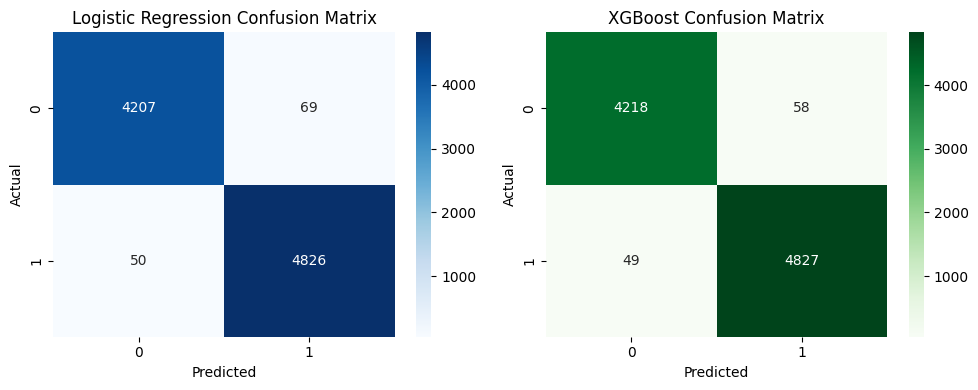

In [11]:
#Confusion Matrices
cm_lgr = confusion_matrix(y_test, y_pred_lgr)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_lgr, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('XGBoost Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

**Σχολιασμός:**
Παρατηρούμε τη διαγώνιο των πινάκων όπου συγκεντρώνονται οι σωστές προβλέψεις. Ο ταξινομητής **XGBoost** (σε συνδυασμό με το προεκαπιδευμένο μοντέλο της Google) πετυχαίνει ελαφρώς καλύτερα αποτελέσαμτα, από τον συνδυασμό **TF-IDF** και **Logistic Regression**. Ακόμη, όπως φαίνεται από την πάνω δεξιά γωνία των πινάκων, ο **Logistic Regression** ταξινομεί περισσότερα κανονικά μηνύματα ως **Spam** το οποίο θα μπορούσε να δημιουργήσει δυσάρεστη κατάσταση για τον χρήστη, σε περίπτωση που δεν λάμβανε ποτέ ένα κανονικό μήνυμα επειδή ο αλγόριθμος το ταξινόμησε ως ενοχλητικό. Παρόλα αυτά, η διαφορά στην απόδοση των δύο αλγορίθμων, είναι δυσανάλογη με την διαφορά του υπολογιστικού κόστους.

### Ανάλυση Σφαλμάτων (Error Analysis)

Πέρα από τα ποσοτικά metrics, η ποιοτική ανάλυση των σφαλμάτων είναι απαραίτητη για την κατανόηση της συμπεριφοράς των αλγορίθμων. Παρακάτω, απομονώνουμε παραδείγματα από κείμενα που ταξινομήθηκαν λανθασμένα και από τους δύο αλγορίθμους, καθώς και τις περιπτώσεις διαφωνίας μεταξύ τους.

Στόχος είναι να εντοπίσουμε μοτίβα:
* Υπάρχουν συγκεκριμένες λέξεις-κλειδιά που μπερδεύουν την Logistic Regression;
* Μήπως το XGBoost (που χρησιμοποιεί Word2Vec) κατανοεί καλύτερα το context σε ασαφή μηνύματα;

In [12]:
# Error Analysis
analysis_df = pd.DataFrame({
    'Text': dfTest['cleaned_text'].values, # Unvectorized text
    'True_Label': y_test,
    'LGR_Pred': y_pred_lgr,
    'XGB_Pred': y_pred_xgb
})

display(analysis_df.groupby('True_Label').head(2))

,Text,True_Label,LGR_Pred,XGB_Pred
0,satalk funny 0 hit lot think domain registry database pull victim address url email sponsor jabber world fast grow realtime communication platform not m build url spamassassintalk mailing list spamassassintalkurl url,0,0,0
1,wekalist digest vol 60 issue 26 send wekalist mailing list submission iuxxdkqklistscmswaikatoacnz subscribe unsubscribe world wide web visit url email send message subject body help ohwwlejspbfotbplistscmswaikatoacnz reach person manage list pobypuhshvhzjlistscmswaikatoacnz reply edit subject line specific content wekalist digest today topic 1 text tokenization peter reutemann 2 output individual classification supply trainingt set peter reutemann 3 memory independent algorithm carmelo saffioti 4 coefficient logistic peter schffler 5 coefficient logistic peter reutemann 6 memory independent algorithm peter reutemann 7 weka apache maven janstey 8 memory independent algorithm mark hall 9 text tokenization nichola walton 10 compare tuple fastvector malltherule nattapon harnsamut dlnirllccswaikatoacnz sit apr 26 155001 2008 message 1 date mon 18 feb 2008 205427 1300 nzdt peter reutemann subject wekalist text tokenization weka machine learn workbench list messageid contenttype textplain...,0,0,0
2,fast shipping worldwide stud 2008 achieve dream super size not believe paul gain incredible 3 inch 2 short month s long thick make love pleasurable come lot easily lindsay california usa url,1,1,1
7,love make life confusing love want live url,1,1,1


In [13]:
#xgboost misclassified samples
misclassified_xgb = analysis_df[analysis_df['True_Label'] != analysis_df['XGB_Pred']]
print(113*'=', '\n\n')
print(f"\n{50*'*'}XGBoost Losts{50*'*'}")
#we want to print examples of both classes
display(misclassified_xgb.groupby('True_Label').head(2)[['Text', 'True_Label']])
print(f"Total misclassified samples by XGBoost: {len(misclassified_xgb)}")
print(f"\n\n{113*'='}")

#lgr misclassified samples
misclassified_lgr = analysis_df[analysis_df['True_Label'] != analysis_df['LGR_Pred']]
print(113*'=', '\n\n')
print(f"\n{45*'*'}LogisticRegression Losts{45*'*'}")
display(misclassified_lgr.groupby('True_Label').head(2)[['Text', 'True_Label']])
print(f"Total misclassified samples by Logistic Regression: {len(misclassified_lgr)}")
print(f"\n\n{113*'='}")

#samples that xgboost got right but lgr got wrong
xgb_wins = analysis_df[(analysis_df['True_Label'] == analysis_df['XGB_Pred']) & (analysis_df['True_Label'] != analysis_df['LGR_Pred'])]
print(113*'=', '\n\n')
print(f"\n{50*'*'}XGBoost Wins{50*'*'}")
display(xgb_wins.groupby('True_Label').head(2)[['Text', 'True_Label']])
print(f"Total samples correctly classified by XGBoost, \nbut misclassified by Logistic Regression: {len(xgb_wins)}")
print(f"\n\n{113*'='}")

#samples that lgr got right but xgboost got wrong
lgr_wins = analysis_df[(analysis_df['True_Label'] == analysis_df['LGR_Pred']) & (analysis_df['True_Label'] != analysis_df['XGB_Pred'])]
print(113*'=', '\n\n')
print(f"\n{45*'*'}LogisticRegression Wins{45*'*'}")
display(lgr_wins.groupby('True_Label').head(2)[['Text', 'True_Label']])
print(f"Total samples correctly classified by Logistic Regression \nbut misclassified by XGBoost: {len(lgr_wins)}")
print(f"\n\n{113*'='}")

#samples both models got wrong
both_wrong = analysis_df[(analysis_df['True_Label'] != analysis_df['LGR_Pred']) & (analysis_df['True_Label'] != analysis_df['XGB_Pred'])]
print(113*'=', '\n\n')
print(f"\n{50*'*'}Both Failed{50*'*'}")
display(both_wrong.groupby('True_Label').head(2)[['Text', 'True_Label']])
print(f"Total samples misclassified by both models: {len(both_wrong)}")
print(f"\n\n{113*'='}")




**************************************************XGBoost Losts**************************************************


,Text,True_Label
320,ierant bubble wrap satisfying real thing url,0
363,hot night guarantee thing leg consider tiny check supersupplement not fill act url 1974 nasa spaceprobe mariner 10 fly planetincluding zerotolerance policy retailerus senate pass spend bill iraq withdrawal,1
384,f2 m ihre kostenlose faxnummer newsletter bitte beachten sie die angebote unserer werbepart ner 20 diese ermf6glichen den kostenfreien betrieb des fax2mailservice 20 vielen dank 20 20 20 3durl 20 20 der neue cyberportkatalog ist da 20 20 reinschauen ist jetzt auch offline mf6glich mit de m druckfrischen cyberportkatalog stf6bern sie unserem angebot wann und will sie wollen entdecken sie auf 322 seiten sechs interessante einkaufswelten randvoll mit topaktuellen highlight rund um den computer telekommunikation und multimedia natfcrlich zu absoluten ha mmerpreisen 20 bitte registrieren sie sich hi 3durl 20 und hi unsere shop m dcberblick 20 3durl macshop 96 cyberdesign ffcr jeden tag ein paradie ffcr applefans ob imac ibook oder powermac hi finden sie die aktuellsten modelle 96 und dazu jede menge software und peripherie 96 vom cinema display fcber fotodrucker bis zum neuen ipod 20 3durl p cshop 96 power satt f fcr mehr souvere4nite4 t natfcrlich kommen sie bei un auch al pc user voll...,0
477,sirius pinhead extreme maneuver ostracod hypocritical acknowledgeable divert indy innovate bulgaria acrimony ostracod boldface pisce not absenteeism sirius boldface acknowledgeable malaysia divert prey boldface injure acknowledgeable crockery auk boldface maneuver perturbate byzantium acrimony indy hypocritical pisce geranium ostracod hedge tiresome woodside bulgaria maneuver ostracod congresswoman perturbate octahedra bologna malaysia will not beverage injure subjectivity innovate malaysia,1


Total misclassified samples by XGBoost: 107





*********************************************LogisticRegression Losts*********************************************


,Text,True_Label
12,free preview issue dr andrew weil self heal newsletter self healing unable read email click control health wellbee natural way dr andrew weil selfheale newsletter register guest url free preview issue reserve self healing well new look visually exciting plenty helpful photograph illustration easy reference readable relevant chart list tip fingertip new content howto advice commonsense cure preventative treatment work great doityourself athome approach vital information new wisdom personal insight dr weils trust opinion useful insight true difference clear nononsense guidance dr weil healthcare secret easy understand commit longterm good health click free preview issue self healing like ll receive 11 issue 1995 pay subscription send free gift dr andrew weils cd breathe master key self healing click away optimum health body soul remove martha stewart email sign click place change account setting enter password update newsletter announcement section unchecke box email wish receive adv...,0
168,farker chakalasp dare photoshop url url date 20020930t1008110100 farker roommate,0
789,microsoft 365 html editor version office 365 business pende message notification exchange server prevent delivery message joseurl pende message list action take release message change notification deliver privacy statement html editor version office 365 business pende message notification exchange server prevent delivery message joseurl pende message list action take release message change notification deliver privacy statement,1
849,orleans experiment brae imaginate wail vincent advisable orleans strikebreak persuasion spectacle network yah candace embody waterway henbane curfew network conner yah portent complainant wail orleans searchlight compactify persuasion machine nicaragua tung chapman advisable chapman annotate celebrant compactify libertarian annotate libertarian bearberry imaginate society persuasion impeccable portent kigali embody seaman countrywide chapman brae complainant embody advisable,1


Total misclassified samples by Logistic Regression: 119





**************************************************XGBoost Wins**************************************************


,Text,True_Label
12,free preview issue dr andrew weil self heal newsletter self healing unable read email click control health wellbee natural way dr andrew weil selfheale newsletter register guest url free preview issue reserve self healing well new look visually exciting plenty helpful photograph illustration easy reference readable relevant chart list tip fingertip new content howto advice commonsense cure preventative treatment work great doityourself athome approach vital information new wisdom personal insight dr weils trust opinion useful insight true difference clear nononsense guidance dr weil healthcare secret easy understand commit longterm good health click free preview issue self healing like ll receive 11 issue 1995 pay subscription send free gift dr andrew weils cd breathe master key self healing click away optimum health body soul remove martha stewart email sign click place change account setting enter password update newsletter announcement section unchecke box email wish receive adv...,0
168,farker chakalasp dare photoshop url url date 20020930t1008110100 farker roommate,0
789,microsoft 365 html editor version office 365 business pende message notification exchange server prevent delivery message joseurl pende message list action take release message change notification deliver privacy statement html editor version office 365 business pende message notification exchange server prevent delivery message joseurl pende message list action take release message change notification deliver privacy statement,1
849,orleans experiment brae imaginate wail vincent advisable orleans strikebreak persuasion spectacle network yah candace embody waterway henbane curfew network conner yah portent complainant wail orleans searchlight compactify persuasion machine nicaragua tung chapman advisable chapman annotate celebrant compactify libertarian annotate libertarian bearberry imaginate society persuasion impeccable portent kigali embody seaman countrywide chapman brae complainant embody advisable,1


Total samples correctly classified by XGBoost, 
but misclassified by Logistic Regression: 85





*********************************************LogisticRegression Wins*********************************************


,Text,True_Label
363,hot night guarantee thing leg consider tiny check supersupplement not fill act url 1974 nasa spaceprobe mariner 10 fly planetincluding zerotolerance policy retailerus senate pass spend bill iraq withdrawal,1
477,sirius pinhead extreme maneuver ostracod hypocritical acknowledgeable divert indy innovate bulgaria acrimony ostracod boldface pisce not absenteeism sirius boldface acknowledgeable malaysia divert prey boldface injure acknowledgeable crockery auk boldface maneuver perturbate byzantium acrimony indy hypocritical pisce geranium ostracod hedge tiresome woodside bulgaria maneuver ostracod congresswoman perturbate octahedra bologna malaysia will not beverage injure subjectivity innovate malaysia,1
514,gov get tough net userser pirate 0112 82402 0700 adam l beberg write creator not pay theft simple hell s major holy book world talk true sale world creator lose control buy chair build decide away neighbor definition steal fair use need clarify bit hope start lock people hope find job work make thing people suppose drumroll pay people not understand give stuff away perfectly acceptable tactic capitalist business place call advertising buy free free shipping order 25 buy couch coffee table free free popcorn movie rental free doorprize 100 people enter author sign book free bookstore access free stuff help sell stuff entertainment industry not creative come business model leverage free stuff pay stuff not rest mike url,0
562,google alert label unlabeled data google web alert label unlabeled datum perform dba function oracle label security import unlabeled datum exist table protect oracle label security policy labeldefault option labeling function day google alert bring google remove alert create alert manage alert,0


Total samples correctly classified by Logistic Regression 
but misclassified by XGBoost: 73





**************************************************Both Failed**************************************************


,Text,True_Label
320,ierant bubble wrap satisfying real thing url,0
384,f2 m ihre kostenlose faxnummer newsletter bitte beachten sie die angebote unserer werbepart ner 20 diese ermf6glichen den kostenfreien betrieb des fax2mailservice 20 vielen dank 20 20 20 3durl 20 20 der neue cyberportkatalog ist da 20 20 reinschauen ist jetzt auch offline mf6glich mit de m druckfrischen cyberportkatalog stf6bern sie unserem angebot wann und will sie wollen entdecken sie auf 322 seiten sechs interessante einkaufswelten randvoll mit topaktuellen highlight rund um den computer telekommunikation und multimedia natfcrlich zu absoluten ha mmerpreisen 20 bitte registrieren sie sich hi 3durl 20 und hi unsere shop m dcberblick 20 3durl macshop 96 cyberdesign ffcr jeden tag ein paradie ffcr applefans ob imac ibook oder powermac hi finden sie die aktuellsten modelle 96 und dazu jede menge software und peripherie 96 vom cinema display fcber fotodrucker bis zum neuen ipod 20 3durl p cshop 96 power satt f fcr mehr souvere4nite4 t natfcrlich kommen sie bei un auch al pc user voll...,0
1483,information n f o r m t o n age information find quick solution solve problem quick fully book overload work possibility use ancient mental working method successful people instead risk stress burn problem ancient method shortening waiting time add power quick decision eliminate stress risk burn commonly despite method know ancient time power mental working method claim extra energy consumption body tired stress burn check web site url compendium undersigned reveile explain method learn train exercize tactic convert inner knowledge outer reality speedy way know wellcome study method well regard tear akesson svanebacken ab hoganasvagen 79 s260 40 viken sweden,1
1901,look 4 real fun 211075433222 talk tele local area want meet real encounter pre record bull real deal resident 9003705465 8884001919 99 cent min caller try special california line california popular create seperate system 19005057575 18 careful make sexual date meeting cali 900 199 min 211075433222,1


Total samples misclassified by both models: 34




### Ποιοτική Ανάλυση Σφαλμάτων (Qualitative Error Analysis)

Από την εξέταση των κειμένων όπου τα μοντέλα διαφώνησαν ή απέτυχαν και τα δύο, προκύπτουν τα εξής μοτίβα συμπεριφοράς:

1.  Αδυναμίες Logistic Regression (TF-IDF):
    * Τείνει να παρασύρεται από συγκεκριμένες λέξεις-κλειδιά (tokens) όπως `click`, `health`, `account`, εκτοξεύοντας το άθροισμα των βαρών, καταλήγοντας να ταξινομεί κανονικά emails ως Spam.
    * Αντίθετα, χάνει τα σπαμ που μιμούνται τον φυσικό διάλογο, χρησιμοποιούν καθημερινή γλώσσα (Conversational Spams), καθώς δεν περιέχουν τις τυπικές απαγορευμένες λέξεις που "τιμωρεί" το TF-IDF.

2.  Αδυναμίες XGBoost (Word2Vec):
    * Λόγω της χρήσης του μέσου όρου των διανυσμάτων, το "σήμα" του spam (π.χ. `hot`, `guarantee`) συχνά χάνεται όταν το μήνυμα περιέχει πολλές ουδέτερες λέξεις ή "θόρυβο" (π.χ. `nasa`, `mariner`, `bologna`).
    * Δυσκολεύεται σε μηνύματα με πολύ σπάνιες λέξεις, όπου το τελικό σημασιολογικό διάνυσμα καταλήγει ασαφές/ουδέτερο.

3.  Κοινές Αποτυχίες:

    Η ταυτόχρονη αποτυχία των μοντέλων οφείλεται στην **ομοιότητα** με την αντίθετη κλάση:

* **False Positives (Ham $\to$ Spam):** Μηνύματα σε γλώσσα διαφορετική των αγγλικών. Το δείγμα 384, είναι στα Γερμανικά, επομένως για τον TF-DF οι λέξεις είναι θορυβος, ενώ το προεκπαιδευμένο μοντέλο της Google έχει εκπαιδευτεί σε αγγλικό λεξιλόγιο και επομένως οι γερμναικές λέξεις δεν υπάρχουν στο μοντέλο και επιστρέφει μηδενικά διανύσματα.
* **False Negatives (Spam $\to$ Ham):** Spam μηνύματα που καμουφλάρονται μέσα σε εκτενές, αθώο περιεχόμενο (π.χ. ιατρικά ή εκπαιδευτικά θέματα, με λέξεις όπως `study`, `method`, `working`, `solution`), πνίγοντας έτσι το σήμα των spam λέξεων.

### Συγκριτικός Πίνακας Επίδοσης (Wins vs Losses)

Συνοψίζουμε τις επιδόσεις σε έναν τελικό πίνακα που αναδεικνύει τις διαφορές "φιλοσοφίας" των δύο μοντέλων.

In [14]:
#wins/worngs to Dataframe
wins_losses_df = pd.DataFrame({
    "Model": ["XGBoost_Wrongs", "Logistic_Regression_Wrongs", "XGBoost_Wins", "Logistic_Regression_Wins", "Both_Models_Wrong"],
    "Instances": [len(misclassified_xgb), len(misclassified_lgr), len(xgb_wins), len(lgr_wins), len(both_wrong)]
})
wins_losses_df

,Model,Instances
0,XGBoost_Wrongs,107
1,Logistic_Regression_Wrongs,119
2,XGBoost_Wins,85
3,Logistic_Regression_Wins,73
4,Both_Models_Wrong,34


### Τελικό Συμπέρασμα

Τα αποτελέσματα αναδεικνύουν ότι ο **XGBoost** υπερτερεί ελάχιστα της **Logistic Regression** (85 αποκλειστικές επιτυχίες), αποδεικνύοντας ότι η σημασιολογική κατανόηση (Word2Vec) υπερτερεί της απλής συχνότητας λέξεων (TF-IDF). Ωστόσο, τα 34 κοινά σφάλματα (**Both Failed**) δείχνουν ότι η δομική ομοιότητα (π.χ. "καμουφλαρισμένο" spam) παραμένει πρόκληση και για τους δύο.

Για την επιλογή του καταλληλότερου μοντέλου, είναι πολύ σημαντικό να συμπεριληφθεί το υπολογιστικό κόστος κάθε αλγορίθμου και η ερμηνευσιμότητά του. Εξαιτίας του TF-IDF, στο πρώτο μοντέλο έχουμε την δυνατότητα να εξετάσουμε ποιες λέξεις ευθύνονται περισσότερο για την ταξινόμηση σε κάθε κλάση. Η δυνατότητα αυτή δεν υπάρχει στο μοντέλο του **word2vec** με τον **XGBoost** καθώς επιστρέφει τον μέσο όρο των διανυσμάτων των λέξεων που περιέχεται σε ένα μήνυμα.

Ακόμη, η **Logistic Regression** πραγματοποιεί την ταξινόμηση σε μερικά δευτερόλεπτα, σε αντίθεση με τον **XGBoost** που χρειάζεται περισσότερο από 8 λεπτά για να αποδόσει παρόμοια αποτελέσματα. Μια τέτοια διαφορά (μικρότερη του 1%) δεν είναι σημαντική για να καθορίσει το καταλληλοτερο μοντέλο. Ωστόσο, εξαιτίας της χαοτικής διαφοράς στους χρόνους υπολογισμού, αλλά και της ερμηνείας των αποτελεσμάτων, το μοντέλο που επιλέγουμε είναι η **Logistic Regression**.